# Tutorial 1.2: Grid search-based two level optimization

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu
<!-- 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/grid_search.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD) -->

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

%matplotlib inline
# plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

## Helper functions

In [3]:
class Dataset(object):
    '''
    Load and parse dataset
    '''

    def __init__(self, dataset_path, input_list, output_list):
        self.dataset_path = dataset_path
        self.input_list, self.output_list = input_list, output_list

        self.df = self._load_dataset()
        self.df_train, self.df_test = self._split_dataset()

    def _load_dataset(self):
        '''load dataset'''
        df = pd.read_csv(self.dataset_path)
        return df
    
    def _split_dataset(self, test_size=0.2, random_state=1):
        '''randomly split dataset'''
        df_train, df_test = train_test_split(self.df, test_size=test_size, random_state=random_state)
        return df_train, df_test

    def parser(self, is_shuffle=True, random_state=0):
        '''load dataset using numpy'''
        X_train = self.df_train[self.input_list].to_numpy()
        y_train = self.df_train[self.output_list].to_numpy().reshape(-1,)

        X_test = self.df_test[self.input_list].to_numpy()
        y_test = self.df_test[self.output_list].to_numpy().reshape(-1,)

        # shuffle
        X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

        return X_train, y_train, X_test, y_test


dataset_path = '../dataset/dataset_keyhole.csv'
input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
output_list = ['e*']

data_loader = Dataset(dataset_path, input_list, output_list)
X_train, y_train, X_test, y_test = data_loader.parser()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(72, 7) (72,) (18, 7) (18,)


In [4]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    def __init__(self, X, y, scaling_mat):
        super(DimensionlessLearning, self).__init__()
        self.X, self.y = X, y
        self.scaling_mat = scaling_mat
        self.basis_num = scaling_mat.shape[1]

    def parse_power_index(self, basis_coef):
        '''
        parse power index based on basis coefficients
        '''
        power_index = np.sum(np.multiply(self.scaling_mat, basis_coef), axis=1)
        return power_index

    def scale_input(self, X, basis_coef):
        '''
        scale the the input data into a few dimensionless numbers
        '''
        power_index = self.parse_power_index(basis_coef)
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        return X_scaled, power_index

    def parse_feats(self, X, deg=5):
        '''
        prepare different degrees' features
        '''
        poly = PolynomialFeatures(deg)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        return X_poly

    def predict(self, X, power_index, scaling_coef, deg=5):
        '''
        based on learned basis coefficients and scaling coefficients to predict
        '''
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        X_poly = self.parse_feats(X_scaled, deg)
        pred = np.sum(np.multiply(X_poly, scaling_coef), axis=1)
        return pred

    def fit(self, method='grid_search', init_point_num=30, seed=0):
        '''
        fit the data
        '''
        BASE = 2 ** 20
        r2, basis_coef, scaling_coef = 0, None, None
        
        for idx in range(init_point_num):
            seed = (idx + seed * init_point_num) % BASE

            if method == 'pattern_search':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_pattern_search(seed=seed)
            elif method == 'grid_search':
                r2_temp, basis_coef_temp, scaling_coef_temp, _ = self.fit_grid_search(seed=seed, verbose=False)
            elif method == 'gradient_descent':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_gradient_descent(seed=seed)
                print('r2_temp, basis_coef_temp, scaling_coef_temp', r2_temp, basis_coef_temp, scaling_coef_temp)
            else:
                raise Exception('Error in the optimizaiton method')

            if r2_temp < r2:
                continue
            r2, basis_coef, scaling_coef = r2_temp, basis_coef_temp, scaling_coef_temp

        return r2, basis_coef, scaling_coef

    def _opt(self, basis_coef):
        '''
        fit a linear regression
        '''
        # prepare polynomial features based on dimensionless numbers
        X_scaled, power_index = self.scale_input(self.X, basis_coef)
        X_poly = self.parse_feats(X_scaled)

        # fit a polynomial
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X_poly, self.y)
        y_pred = reg.predict(X_poly)
        r2 = r2_score(self.y, y_pred)
        scaling_coef = reg.coef_

        return r2, power_index, scaling_coef

    def fit_grid_search(self, grid_range=[-2, 2], n_grids=100, clip_threshold=0.2, seed=0, gamma0=0.5, top_k=10, verbose=True, return_landscape=False):
        '''
        grid search-based optimization

        Args:
            grid_range [list of float]: the range for each basis coefficient (default: [-2, 2]);
            n_grids [int]: number of grid points for each dimension (default: 100);
            clip_threshold [float]: if the R2 score for a point is lower than this threshold, skip it;
            seed [int]: random seed for reproducibility;
            gamma0 [float]: predefined value for the first basis coefficient (default: 0.5);
            top_k [int]: number of top candidates to save and return (default: 10);
            verbose [bool]: whether to print progress and results (default: True);
            return_landscape [bool]: whether to return R2 landscape data for visualization (default: False);
        Return:
            r2 [float]: the final R2 score
            power_index [array]: the power law index for one input dimensionless nunber
            scaling_coef [array]: the scaling law coefficients
            top_candidates [list]: list of top k candidates with their details
            r2_landscape [dict]: R2 landscape data for visualization (only if return_landscape=True)
        '''
        def _generate_grid_points(basis_num, grid_range, n_grids, gamma0):
            '''
            generate all possible grid points for grid search
            Note: first basis coefficient is fixed to gamma0
            '''
            # Create grid for remaining dimensions (excluding the first one)
            gamma_values = np.linspace(grid_range[0], grid_range[1], n_grids)
            
            # Generate all combinations for remaining dimensions
            if basis_num > 1:
                grids = np.meshgrid(*[gamma_values for _ in range(basis_num - 1)])
                remaining_coefs = np.column_stack([grid.ravel() for grid in grids])
                
                # Add the fixed first coefficient to all combinations
                grid_points = np.column_stack([
                    np.full(remaining_coefs.shape[0], gamma0),  # Fixed first coefficient
                    remaining_coefs  # Variable remaining coefficients
                ])
            else:
                # Only one dimension, just use the fixed value
                grid_points = np.array([[gamma0]])
            
            return grid_points

        # Set random seed for reproducibility
        np.random.seed(seed)
        
        # Generate all grid points (with first coefficient fixed)
        grid_points = _generate_grid_points(self.basis_num, grid_range, n_grids, gamma0)
        
        if verbose:
            print(f'[Grid Search] Evaluating {len(grid_points)} grid points...')
            print(f'[Grid Search] Grid range: {grid_range}, Grid points per dimension: {n_grids}')
            print(f'[Grid Search] First basis coefficient fixed to: {gamma0}')
            print(f'[Grid Search] Saving top {top_k} candidates')
        
        candidates = []  # List to store (r2, basis_coef, power_index, scaling_coef, l1_norm)
        
        # Initialize landscape data collection if requested
        if return_landscape:
            r2_landscape = {
                'gamma2_values': [],  # Second basis coefficient
                'gamma3_values': [],  # Third basis coefficient  
                'r2_scores': [],      # R2 scores
                'valid_points': []    # Valid grid points
            }
        
        # Evaluate each grid point
        for i, basis_coef in enumerate(grid_points):
            try:
                r2, power_index, scaling_coef = self._opt(basis_coef)
                
                # Collect landscape data if requested
                if return_landscape:
                    r2_landscape['gamma2_values'].append(basis_coef[1])
                    r2_landscape['gamma3_values'].append(basis_coef[2])
                    r2_landscape['r2_scores'].append(r2)
                    r2_landscape['valid_points'].append(r2 >= clip_threshold)
                
                if r2 < clip_threshold:
                    continue
                
                l1_norm = np.sum(np.abs(power_index))
                candidates.append((r2, basis_coef.copy(), power_index.copy(), scaling_coef.copy(), l1_norm))
                candidates.sort(key=lambda x: x[0], reverse=True)
                if len(candidates) > top_k:
                    candidates = candidates[:top_k]
                    
            except Exception as e:
                if return_landscape:
                    r2_landscape['gamma2_values'].append(basis_coef[1])
                    r2_landscape['gamma3_values'].append(basis_coef[2])
                    r2_landscape['r2_scores'].append(0.0)
                    r2_landscape['valid_points'].append(False)
                continue
                
            if verbose and (i + 1) % max(1, len(grid_points) // 10) == 0:
                best_r2_so_far = candidates[0][0] if candidates else 0
                print(f'[Grid Search] Progress: {i+1}/{len(grid_points)} ({100*(i+1)/len(grid_points):.1f}%), Best R2: {best_r2_so_far:.4f}')

        # If no valid solution found, return zeros
        if not candidates:
            if verbose:
                print('[Grid Search] Warning: No valid solution found, returning zeros')
            best_basis_coef = np.zeros(self.basis_num)
            best_power_index = np.zeros(self.basis_num)
            best_scaling_coef = np.zeros(6)  # Assuming degree 5 polynomial
            best_r2 = 0
            top_candidates = []
        else:
            # Get the best result (first in sorted list)
            best_r2, best_basis_coef, best_power_index, best_scaling_coef, best_l1_norm = candidates[0]
            
            # Prepare top k candidates for display
            top_candidates = []
            for i, (r2, basis_coef, power_index, scaling_coef, l1_norm) in enumerate(candidates):
                top_candidates.append({
                    'rank': i + 1,
                    'r2': r2,
                    'basis_coef': basis_coef,
                    'power_index': power_index,
                    'scaling_coef': scaling_coef,
                    'l1_norm': l1_norm
                })

        if verbose:
            print(f'[Grid Search] Best R2: {best_r2:.4f}')
            print(f'[Grid Search] Best basis coefficients: {best_basis_coef}')
            print(f'[Grid Search] Best L1 norm of power index: {best_l1_norm:.4f}')
            
            # Display top k candidates
            print(f'\n[Grid Search] Top {len(top_candidates)} Candidates:')
            print('Rank | R2 Score | L1 Norm | Basis Coefficients')
            print('-' * 60)
            for candidate in top_candidates:
                print(f"{candidate['rank']:4d} | {candidate['r2']:8.4f} | {candidate['l1_norm']:7.4f} | {candidate['basis_coef']}")
        
        if return_landscape:
            return best_r2, best_power_index, best_scaling_coef, top_candidates, r2_landscape
        else:
            return best_r2, best_power_index, best_scaling_coef, top_candidates

[Dataset] X_train: (72, 7), y_train: (72,)
[Dataset] X_test: (18, 7), y_test: (18,)
[Training]
[Grid Search] Evaluating 441 grid points...
[Grid Search] Grid range: [-2, 2], Grid points per dimension: 21
[Grid Search] First basis coefficient fixed to: 0.5
[Grid Search] Saving top 10 candidates
[Grid Search] Progress: 44/441 (10.0%), Best R2: 0.6619
[Grid Search] Progress: 88/441 (20.0%), Best R2: 0.6731
[Grid Search] Progress: 132/441 (29.9%), Best R2: 0.6731
[Grid Search] Progress: 176/441 (39.9%), Best R2: 0.6731
[Grid Search] Progress: 220/441 (49.9%), Best R2: 0.6731
[Grid Search] Progress: 264/441 (59.9%), Best R2: 0.6731
[Grid Search] Progress: 308/441 (69.8%), Best R2: 0.9425
[Grid Search] Progress: 352/441 (79.8%), Best R2: 0.9841
[Grid Search] Best R2: 0.9841
[Grid Search] Best basis coefficients: [0.5 1.  1. ]
[Grid Search] Best L1 norm of power index: 6.5000

[Grid Search] Top 10 Candidates:
Rank | R2 Score | L1 Norm | Basis Coefficients
-------------------------------------

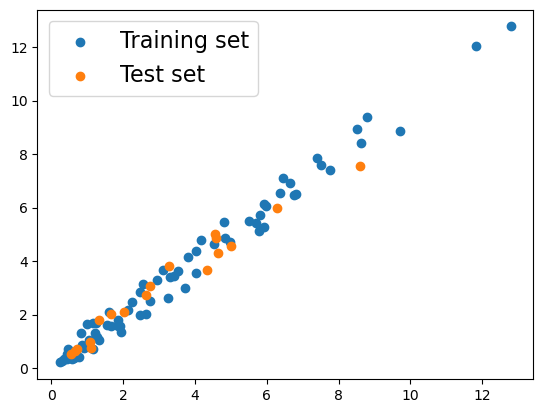

[Ideal Solution]


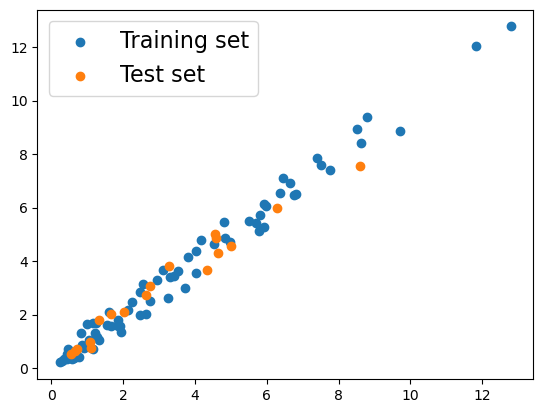

Ideal solution R²: 0.9841
power_index_ideal: [ 1.  -0.5 -1.5 -0.5 -1.  -1.  -1. ]
scaling_coef_ideal: [-0.14717072  0.06325514  0.0038886  -0.00009134  0.00000091 -0.        ]
Best found R²: 0.9841
[3D R² Landscape Visualization]


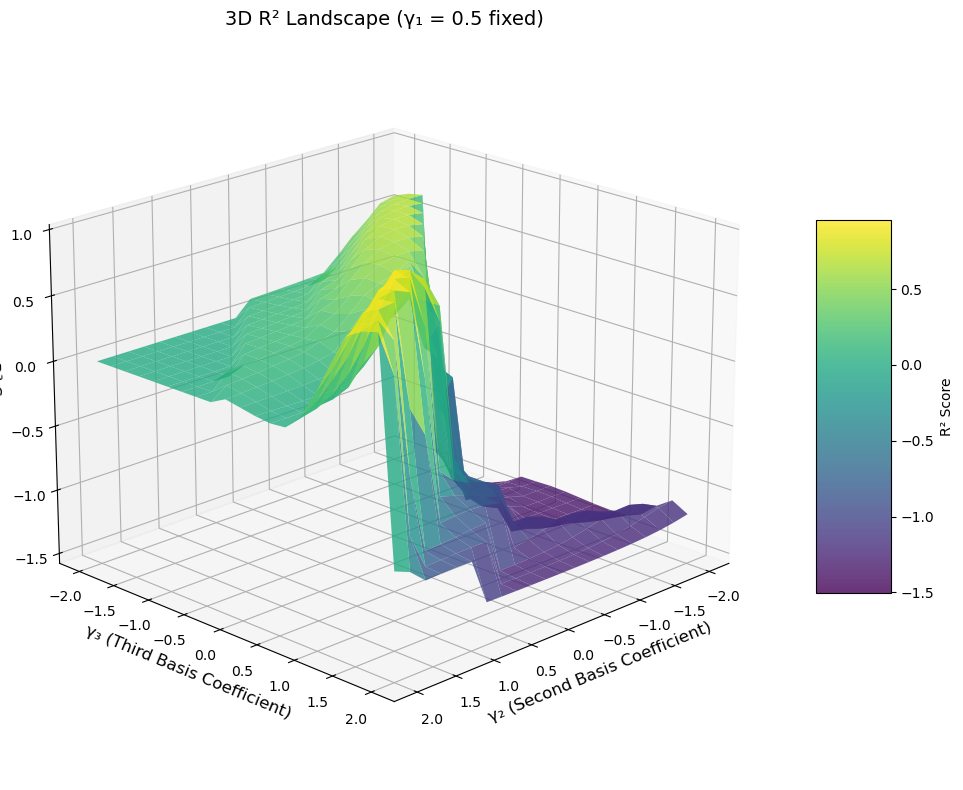

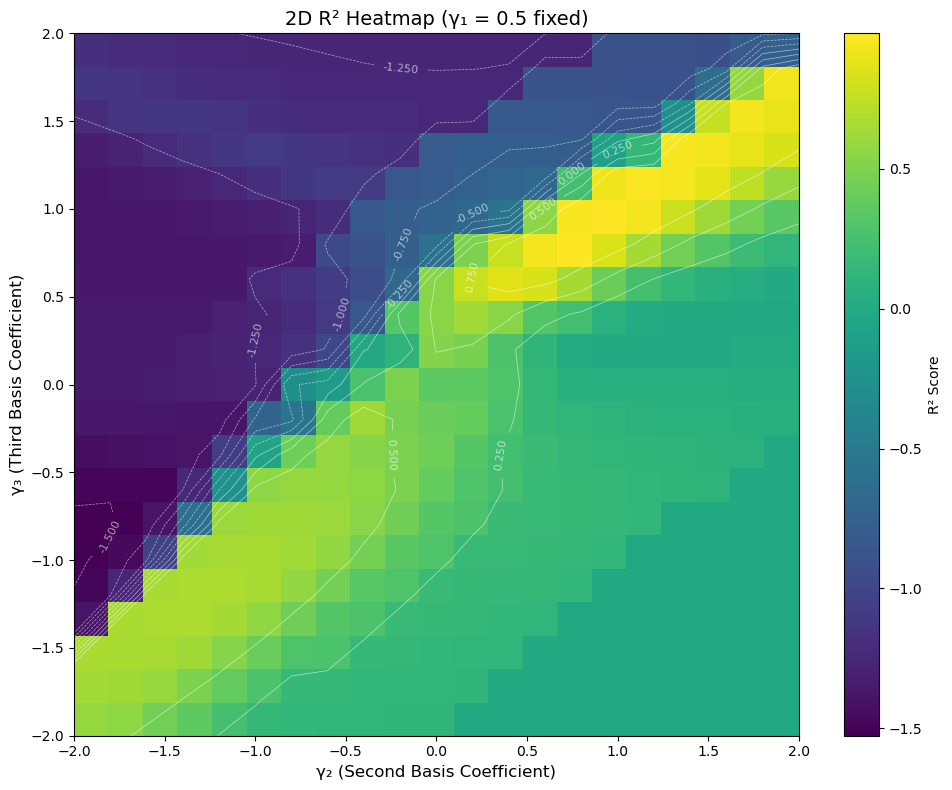

[Landscape Analysis]
R² range: [-1.5267, 0.9841]
Valid points: 125/441 (28.3%)
Best R²: 0.9841
Best γ₂: 1.000, Best γ₃: 1.000


In [5]:
def plot_r2_landscape_3d(r2_landscape, n_grids):
    '''
    Plot 3D landscape of R2 scores
    
    Args:
        r2_landscape [dict]: landscape data from fit_grid_search
        n_grids [int]: number of grid points per dimension
    '''
    from mpl_toolkits.mplot3d import Axes3D
    
    # Convert to numpy arrays
    gamma2 = np.array(r2_landscape['gamma2_values'])
    gamma3 = np.array(r2_landscape['gamma3_values'])
    r2_scores = np.array(r2_landscape['r2_scores'])
    valid_points = np.array(r2_landscape['valid_points'])
    
    # Reshape to grid format
    gamma2_grid = gamma2.reshape(n_grids, n_grids)
    gamma3_grid = gamma3.reshape(n_grids, n_grids)
    r2_grid = r2_scores.reshape(n_grids, n_grids)
    valid_grid = valid_points.reshape(n_grids, n_grids)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(gamma2_grid, gamma3_grid, r2_grid, 
                          cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    
    # Add colorbar
    fig.colorbar(surf, shrink=0.5, aspect=5, label='R² Score')
    
    # Set labels and title
    ax.set_xlabel('γ₂ (Second Basis Coefficient)', fontsize=12)
    ax.set_ylabel('γ₃ (Third Basis Coefficient)', fontsize=12)
    ax.set_zlabel('R² Score', fontsize=12)
    ax.set_title('3D R² Landscape (γ₁ = 0.5 fixed)', fontsize=14)
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Also create a 2D heatmap for better visibility
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(r2_grid, cmap='viridis', aspect='auto', origin='lower',
                   extent=[gamma2.min(), gamma2.max(), gamma3.min(), gamma3.max()])
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label='R² Score')
    
    # Set labels and title
    ax.set_xlabel('γ₂ (Second Basis Coefficient)', fontsize=12)
    ax.set_ylabel('γ₃ (Third Basis Coefficient)', fontsize=12)
    ax.set_title('2D R² Heatmap (γ₁ = 0.5 fixed)', fontsize=14)
    
    # Add contour lines
    contour = ax.contour(gamma2_grid, gamma3_grid, r2_grid, levels=10, colors='white', alpha=0.6, linewidths=0.5)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f'[Landscape Analysis]')
    print(f'R² range: [{r2_scores.min():.4f}, {r2_scores.max():.4f}]')
    print(f'Valid points: {valid_points.sum()}/{len(valid_points)} ({100*valid_points.sum()/len(valid_points):.1f}%)')
    print(f'Best R²: {r2_scores.max():.4f}')
    best_idx = np.argmax(r2_scores)
    print(f'Best γ₂: {gamma2[best_idx]:.3f}, Best γ₃: {gamma3[best_idx]:.3f}')
    

def test_keyhole_example(method, n_grids):
    '''
    keyhole problem
    '''
    ################################### config ###################################
    dataset_path = '../dataset/dataset_keyhole.csv'
    input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
    output_list = ['e*']
    
    # dimension matrix
    D_in = np.array(
        [
            [2., 1., 1., 2., -3., 2., 0.],
            [-3., -1., 0., -1., 0., -2., 0.],
            [1., 0., 0., 0., 1., 0., 0.],
            [0., 0., 0., 0., 0., -1., 1.],
        ],
    )
    D_out = np.array(
        [
            [1.],
            [0.],
            [0.],
            [0.],
        ]
    )
    # best weights for Ke: 0.5, 1, 1
    # basis vectors in columns
    scaling_mat = np.array(
        [
            [0., 0., 1],
            [1, 2., -3],
            [1, 0., -2.],
            [-1, 0., 0.],
            [0., 0., -1],
            [0., -1, 0.],
            [0., -1, 0.]],
    )
    deg = 5

    ################################### dataset ########################################
    # load, split, and shuffle the dataset
    data_loader = Dataset(dataset_path, input_list, output_list)
    X_train, y_train, X_test, y_test = data_loader.parser()
    print(f'[Dataset] X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] X_test: {X_test.shape}, y_test: {y_test.shape}')

    ################################### training and testing ###########################
    print('[Training]')
    dimensionless_learning = DimensionlessLearning(X_train, y_train, scaling_mat)
    
    if method == 'grid_search':
        r2, power_index, scaling_coef, top_candidates, r2_landscape = dimensionless_learning.fit_grid_search(
            grid_range=[-2, 2], n_grids=n_grids, clip_threshold=0.2, seed=0, gamma0=0.5, top_k=10, verbose=True, return_landscape=True
        )
    else:
        r2, power_index, scaling_coef = dimensionless_learning.fit(method=method)
        top_candidates = []
    
    print(f'Final r2: {r2:.4f}, power_index: {power_index}, scaling_coef: {scaling_coef}')
    pred_train = dimensionless_learning.predict(X_train, power_index, scaling_coef, deg)
    pred_test = dimensionless_learning.predict(X_test, power_index, scaling_coef, deg)

    ################################### visualization ###################################
    print('[Visualization]')
    fig = plt.figure()
    plt.scatter(pred_train, y_train, label='Training set')
    plt.scatter(pred_test, y_test, label='Test set')
    plt.legend(fontsize=16)
    plt.show()

    ################################### plot the selected solution ###################################
    print('[Ideal Solution]')
    optimal_gamma = [0.5, 1.0, 1.0]
    r2_ideal, power_index_ideal, scaling_coef_ideal = dimensionless_learning._opt(np.array(optimal_gamma))
    pred_train_ideal = dimensionless_learning.predict(X_train, power_index_ideal, scaling_coef_ideal, deg)
    pred_test_ideal = dimensionless_learning.predict(X_test, power_index_ideal, scaling_coef_ideal, deg)
    
    fig = plt.figure()
    plt.scatter(pred_train_ideal, y_train, label='Training set')
    plt.scatter(pred_test_ideal, y_test, label='Test set')
    plt.legend(fontsize=16)
    plt.show()
    
    print(f'Ideal solution R²: {r2_ideal:.4f}')
    print(f'power_index_ideal: {power_index_ideal}')
    print(f'scaling_coef_ideal: {scaling_coef_ideal}')
    print(f'Best found R²: {r2:.4f}')
    
    ################################### 3D R2 landscape visualization ###################################
    if method == 'grid_search' and 'r2_landscape' in locals():
        print('[3D R² Landscape Visualization]')
        plot_r2_landscape_3d(r2_landscape, n_grids)


method = 'grid_search'
n_grids = 21  # Smaller grid for faster 3D visualization
test_keyhole_example(method, n_grids)
# the No. 1 candidate is the optimal solution

[Dataset] X_train: (72, 7), y_train: (72,)
[Dataset] X_test: (18, 7), y_test: (18,)
[Training]
[Grid Search] Evaluating 10201 grid points...
[Grid Search] Grid range: [-2, 2], Grid points per dimension: 101
[Grid Search] First basis coefficient fixed to: 0.5
[Grid Search] Saving top 10 candidates
[Grid Search] Progress: 1020/10201 (10.0%), Best R2: 0.6622
[Grid Search] Progress: 2040/10201 (20.0%), Best R2: 0.6754
[Grid Search] Progress: 3060/10201 (30.0%), Best R2: 0.6754
[Grid Search] Progress: 4080/10201 (40.0%), Best R2: 0.6754
[Grid Search] Progress: 5100/10201 (50.0%), Best R2: 0.7331
[Grid Search] Progress: 6120/10201 (60.0%), Best R2: 0.7331
[Grid Search] Progress: 7140/10201 (70.0%), Best R2: 0.9792
[Grid Search] Progress: 8160/10201 (80.0%), Best R2: 0.9870
[Grid Search] Progress: 9180/10201 (90.0%), Best R2: 0.9870
[Grid Search] Best R2: 0.9870
[Grid Search] Best basis coefficients: [0.5  0.92 0.92]
[Grid Search] Best L1 norm of power index: 5.9400

[Grid Search] Top 10 Cand

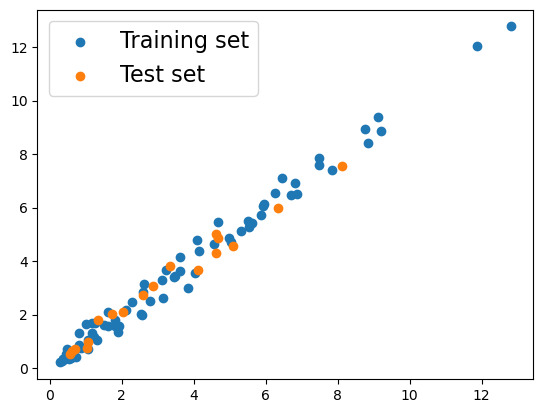

[Ideal Solution]


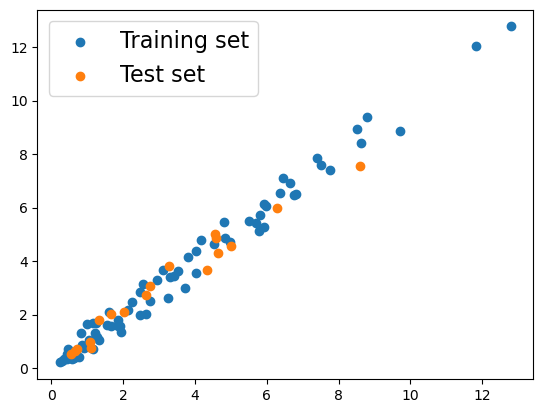

Ideal solution R²: 0.9841
power_index_ideal: [ 1.  -0.5 -1.5 -0.5 -1.  -1.  -1. ]
scaling_coef_ideal: [-0.14717072  0.06325514  0.0038886  -0.00009134  0.00000091 -0.        ]
Best found R²: 0.9870
[3D R² Landscape Visualization]


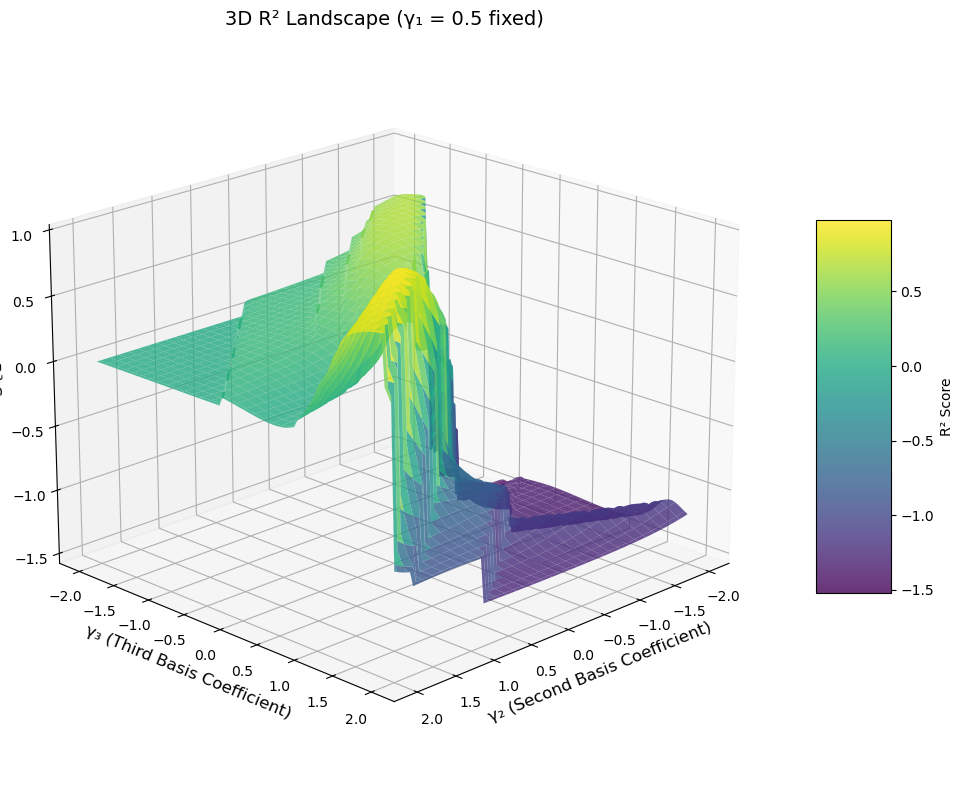

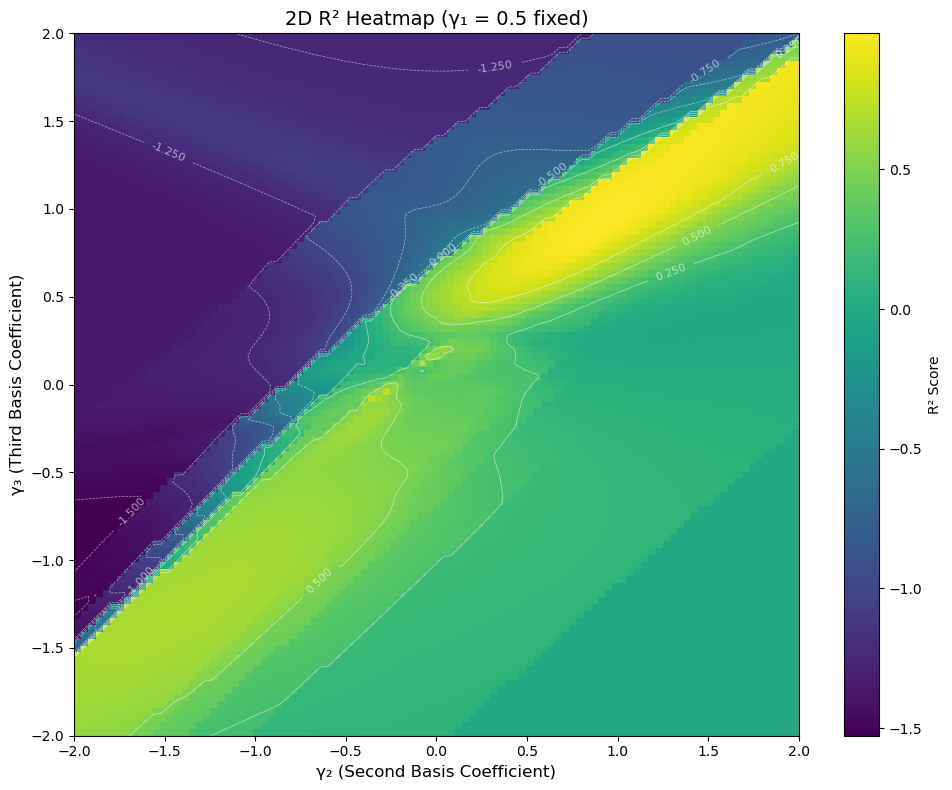

[Landscape Analysis]
R² range: [-1.5270, 0.9870]
Valid points: 2961/10201 (29.0%)
Best R²: 0.9870
Best γ₂: 0.920, Best γ₃: 0.920


In [7]:
n_grids = 101
test_keyhole_example(method, n_grids)
# the No.8 candidate is the optimal solution, since it has a simpler basis coefficients